This script calculates the driver income per shift

## Load packages

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

## Load data

In [2]:
trip_df = pd.read_csv('../data/trip_cleaned.csv')

## Generate shift id for each shift

In [3]:
cols = ['hack_license', 'pickup_datetime', 'dropoff_datetime', 'total_amount', 'first_pickup']
trip_df_income = trip_df[cols]
trip_df_income.loc[:,'pickup_datetime'] = pd.to_datetime(trip_df_income['pickup_datetime'])
trip_df_income.loc[:,'dropoff_datetime'] = pd.to_datetime(trip_df_income['dropoff_datetime'])
trip_df_income.loc[:,'shift_id'] = trip_df_income['first_pickup'].cumsum()

D:\Ananconda\install\envs\py3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Ananconda\install\envs\py3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


## Get start, end time and total income of each shift

In [4]:
shifts_income = trip_df_income.groupby(['shift_id']).agg({'total_amount':np.sum,
                                                          'pickup_datetime':np.min,
                                                          'dropoff_datetime':np.max}).reset_index()
shifts_income['pickup_weekday'] = (shifts_income.loc[:,'pickup_datetime'].dt.dayofweek // 5 == 0).astype(int)
shifts_income['dropoff_weekday'] = (shifts_income.loc[:,'dropoff_datetime'].dt.dayofweek // 5 == 0).astype(int)

shifts_income.head()

,shift_id,total_amount,pickup_datetime,dropoff_datetime,pickup_weekday,dropoff_weekday
0,0.0,98.10,2013-06-24 18:55:00,2013-06-24 22:13:00,1,1
1,1.0,278.78,2013-06-26 17:24:00,2013-06-27 00:44:00,1,1
2,2.0,372.00,2013-06-27 17:20:00,2013-06-28 01:26:00,1,1
3,3.0,401.35,2013-06-28 18:08:00,2013-06-29 02:58:00,1,0
4,4.0,390.34,2013-06-29 18:07:00,2013-06-30 04:49:00,0,0


## Identify morning and night shift for weekday and weekend

In [5]:
# copy from EDA_activetime_dist.ipnb
def get_shift(time, weekday=True, pickup=True):
    if weekday:
        if pickup:
            if (time > datetime.time(23, 30)) | (time <= datetime.time(11, 30)):
                return 'A'
            else:
                return 'B'
        else:
            if (time > datetime.time(8, 30)) & (time <= datetime.time(20, 30)):
                return 'A'
            else:
                return 'B'            
    else: ## weekend
        if pickup:
            if (time > datetime.time(2, 0)) & (time <= datetime.time(14, 0)):
                return 'A'
            else:
                return 'B'
        else:
            if (time > datetime.time(10, 0)) & (time <= datetime.time(22, 0)):
                return 'A'
            else:
                return 'B'        
        return None

In [6]:
shifts_income.loc[:,'PU_time'] = shifts_income['pickup_datetime'].apply(lambda x: x.time())
shifts_income.loc[:,'DO_time'] = shifts_income['dropoff_datetime'].apply(lambda x: x.time())
shifts_income.loc[(shifts_income['pickup_weekday']==1), '_PU_shift'] = shifts_income.PU_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=True))
shifts_income.loc[(shifts_income['dropoff_weekday']==1), '_DO_shift'] = shifts_income.DO_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=False))

## determine shift for weekends
shifts_income.loc[(shifts_income['pickup_weekday']==0) , '_PU_shift'] = shifts_income.PU_time\
                                .apply(lambda x: get_shift(x, weekday=False, pickup=True))
shifts_income.loc[(shifts_income['dropoff_weekday']==0), '_DO_shift'] = shifts_income.DO_time\
                                .apply(lambda x: get_shift(x, weekday=False, pickup=False))
shifts_income.head()

,shift_id,total_amount,pickup_datetime,dropoff_datetime,pickup_weekday,dropoff_weekday,PU_time,DO_time,_PU_shift,_DO_shift
0,0.0,98.10,2013-06-24 18:55:00,2013-06-24 22:13:00,1,1,18:55:00,22:13:00,B,B
1,1.0,278.78,2013-06-26 17:24:00,2013-06-27 00:44:00,1,1,17:24:00,00:44:00,B,B
2,2.0,372.00,2013-06-27 17:20:00,2013-06-28 01:26:00,1,1,17:20:00,01:26:00,B,B
3,3.0,401.35,2013-06-28 18:08:00,2013-06-29 02:58:00,1,0,18:08:00,02:58:00,B,B
4,4.0,390.34,2013-06-29 18:07:00,2013-06-30 04:49:00,0,0,18:07:00,04:49:00,B,B


## Check outliers
Drop income higher than $1000 in a single shift

In [7]:
N = shifts_income.shape[0]
n0 = len(shifts_income.loc[(shifts_income['total_amount']>1000), 'total_amount'])
n1 = len(shifts_income.loc[(shifts_income['total_amount']<=100), 'total_amount'])
n2 = len(shifts_income.loc[(shifts_income['total_amount']<500), 'total_amount'])
print('{n0} ({n0_per:.2f}%) records: driver income per shift > $1000\n\
{n1} ({n1_per:.2f}%) records: driver income per shift < $100\n\
{n2} ({n2_per:.2f}%) records: driver income per shift < $500\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                                  n1 = n1, n1_per = n1/N*100,
                                                                  n2 = n2, n2_per = n2/N*100))
print(shifts_income['total_amount'].describe())

1083 (0.17%) records: driver income per shift > $1000
20755 (3.28%) records: driver income per shift < $100
588635 (92.92%) records: driver income per shift < $500
count    633454.000000
mean        326.428159
std         132.283864
min           3.500000
25%         251.660000
50%         319.810000
75%         389.760000
max        7739.640000
Name: total_amount, dtype: float64


In [8]:
index_income = (shifts_income['total_amount']<=1000)

## Plot income distribution

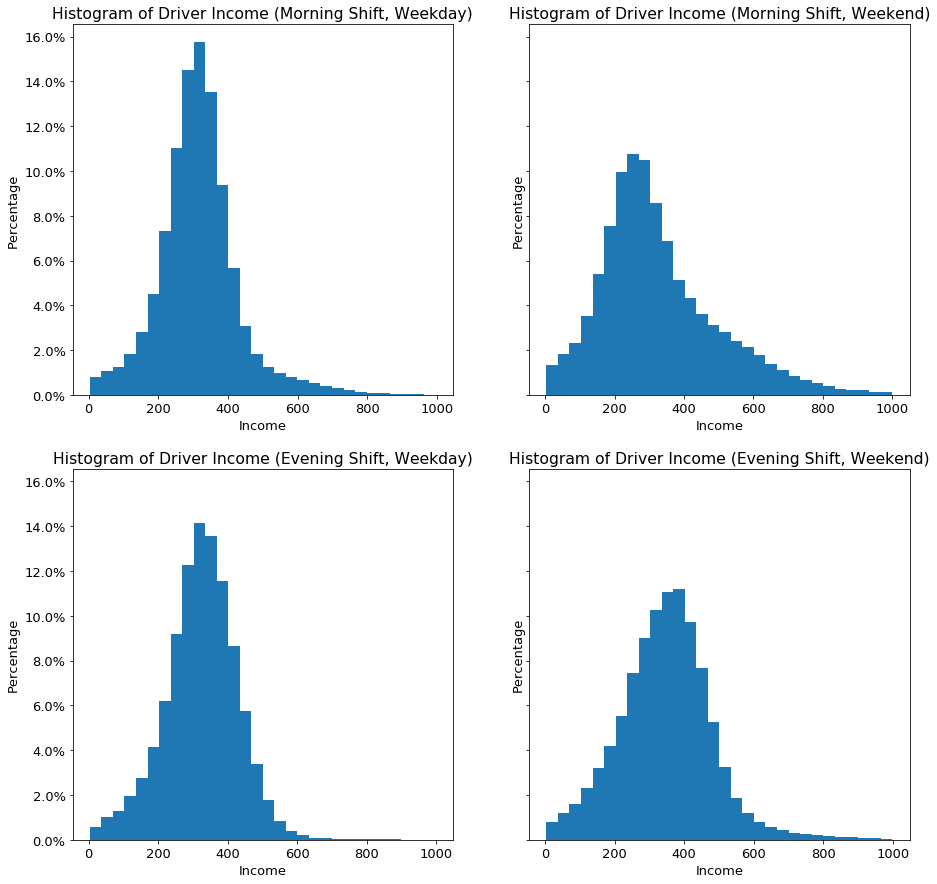

In [21]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(2,2, figsize=(15,15), sharey=True)

data = shifts_income.loc[index_income & 
                         (shifts_income['pickup_weekday'] == 1) & 
                         (shifts_income['_PU_shift'] == 'A')]['total_amount']
ax[0,0].hist(data, weights=np.ones(len(data)) / len(data), bins=30)
ax[0,0].set_title('Histogram of Driver Income (Morning Shift, Weekday)');
ax[0,0].set_xlabel('Income');
ax[0,0].set_ylabel('Percentage');
ax[0,0].yaxis.set_major_formatter(PercentFormatter(1))

data = shifts_income.loc[index_income & 
                         (shifts_income['pickup_weekday'] == 0) & 
                         (shifts_income['_PU_shift'] == 'A')]['total_amount']
ax[0,1].hist(data, weights=np.ones(len(data)) / len(data), bins=30)
ax[0,1].set_title('Histogram of Driver Income (Morning Shift, Weekend)');
ax[0,1].set_xlabel('Income');
ax[0,1].set_ylabel('Percentage');
ax[0,1].yaxis.set_major_formatter(PercentFormatter(1))

data = shifts_income.loc[index_income & 
                         (shifts_income['pickup_weekday'] == 1) & 
                         (shifts_income['_PU_shift'] == 'B')]['total_amount']
ax[1,0].hist(data, weights=np.ones(len(data)) / len(data), bins=30)
ax[1,0].set_title('Histogram of Driver Income (Evening Shift, Weekday)');
ax[1,0].set_xlabel('Income');
ax[1,0].set_ylabel('Percentage');
ax[1,0].yaxis.set_major_formatter(PercentFormatter(1))

data = shifts_income.loc[index_income & 
                         (shifts_income['pickup_weekday'] == 0) & 
                         (shifts_income['_PU_shift'] == 'B')]['total_amount']
ax[1,1].hist(data, weights=np.ones(len(data)) / len(data), bins=30)
ax[1,1].set_title('Histogram of Driver Income (Evening Shift, Weekend)');
ax[1,1].set_xlabel('Income');
ax[1,1].set_ylabel('Percentage');
ax[1,1].yaxis.set_major_formatter(PercentFormatter(1))


fig.savefig('../fig/driver_income.png');